In [ ]:
#https://data-science-blog.com/blog/2021/02/17/sequence-to-sequence-models-back-bones-of-various-nlp-tasks/
#https://towardsdatascience.com/text-summarization-from-scratch-using-encoder-decoder-network-with-attention-in-keras-5fa80d12710e

In [2]:
from keras.layers.normalization import layer_normalization


In [3]:
import hashlib
import os
from typing import Dict, List
import pandas as pd

import matplotlib.pyplot as plt
import scikitplot as skplt
from absl import logging

import tensorflow as tf
import tensorflow_datasets.public_api as tfds
#from tensorflow_datasets.core.utils.lazy_imports_utils 
import tensorflow as tf

In [4]:
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
from tensorflow.keras.layers import Attention

In [5]:
import tensorflow as tf

device = tf.config.list_physical_devices('GPU')
#tf.device('cuda:1' if tf.cuda.is_available() else 'cpu')

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [6]:
from tensorflow.python.keras import backend as K

In [7]:
class AttentionLayer(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

#         logger.debug(f"encoder_out_seq.shape = {encoder_out_seq.shape}")
#         logger.debug(f"decoder_out_seq.shape = {decoder_out_seq.shape}")

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

#             logger.debug("Running energy computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_full_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim

            #logger.debug(f"U_a_dot_h.shape = {U_a_dot_h.shape}")

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            #logger.debug(f"Ws_plus_Uh.shape = {Ws_plus_Uh.shape}")

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            #logger.debug(f"ei.shape = {e_i.shape}")

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            #logger.debug("Running attention vector computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_full_seq * K.expand_dims(inputs, -1), axis=1)

            #logger.debug(f"ci.shape = {c_i.shape}")

            return c_i, [c_i]

        # we don't maintain states between steps when computing attention
        # attention is stateless, so we're passing a fake state for RNN step function
        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e], constants=[encoder_out_seq]
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c], constants=[encoder_out_seq]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [8]:
#https://github.com/sunnysai12345/News_Summary/blob/master/news_summary_more.csv
data = pd.read_csv(r'/kaggle/input/news-summary/news_summary_more.csv', encoding = 'unicode_escape')



In [9]:
data.drop(data.tail(10000).index,
        inplace = True)


In [10]:
data.head(10)

,headlines,text
0,upGrad learner switches to career in ML & Al with 90% salary hike,"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program ..."
1,Delhi techie wins free food from Swiggy for one year on CRED,"Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coi..."
2,New Zealand end Rohit Sharma-led India's 12-match winning streak,New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's capt...
3,Aegon life iTerm insurance plan helps customers save tax,"With Aegon Life iTerm Insurance plan, customers can enjoy tax benefits on your premiums paid and save up to Ã¢ÂÂ¹46,800^ on taxes. The plan provides life cover up to the age of 100 years. Also, c..."
4,"Have known Hirani for yrs, what if MeToo claims are not true: Sonam","Speaking about the sexual harassment allegations against Rajkumar Hirani, Sonam Kapoor said, ""I've known Hirani for many years...What if it's not true, the [#MeToo] movement will get derailed."" ""I..."
5,Rahat Fateh Ali Khan denies getting notice for smuggling currency,"Pakistani singer Rahat Fateh Ali Khan has denied receiving any notice from the Enforcement Directorate over allegedly smuggling foreign currency out of India. ""It would have been better if the aut..."
6,"India get all out for 92, their lowest ODI total in New Zealand",India recorded their lowest ODI total in New Zealand after getting all out for 92 runs in 30.5 overs in the fourth ODI at Hamilton on Thursday. Seven of India's batsmen were dismissed for single-d...
7,Govt directs Alok Verma to join work 1 day before his retirement,"Weeks after ex-CBI Director Alok Verma told the Department of Personnel and Training to consider him retired, the Home Ministry asked him to join work on the last day of his fixed tenure as Direct..."
8,Called PM Modi 'sir' 10 times to satisfy his ego: Andhra CM,"Andhra Pradesh CM N Chandrababu Naidu has said, ""When I met then US President Bill Clinton, I addressed him as Mr Clinton, not as 'sir'. (PM Narendra) Modi is my junior in politics...I addressed h..."
9,"Cong wins Ramgarh bypoll in Rajasthan, takes total to 100 seats","Congress candidate Shafia Zubair won the Ramgarh Assembly seat in Rajasthan, by defeating BJP's Sukhwant Singh with a margin of 12,228 votes in the bypoll. With this victory, Congress has taken it..."


In [11]:
data = data.rename(columns={"headlines": "Summary"})
data = data.rename(columns={"text": "article"})

In [12]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [13]:
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in data['article']:
    cleaned_text.append(text_cleaner(t))

In [14]:
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

#Call the above function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))

data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

In [15]:
data

,Summary,article,cleaned_text,cleaned_summary
0,upGrad learner switches to career in ML & Al with 90% salary hike,"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program ...",saurav kant alumnus upgrad iiit program machine learning artificial intelligence systems engineer infosys almost years work experience program upgrad degree career support helped transition data s...,upgrad learner switches to career in ml al with salary hike
1,Delhi techie wins free food from Swiggy for one year on CRED,"Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coi...",kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bi...,delhi techie wins free food from swiggy for one year on cred
2,New Zealand end Rohit Sharma-led India's 12-match winning streak,New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's capt...,new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march ...,new zealand end rohit sharma led india match winning streak
3,Aegon life iTerm insurance plan helps customers save tax,"With Aegon Life iTerm Insurance plan, customers can enjoy tax benefits on your premiums paid and save up to Ã¢ÂÂ¹46,800^ on taxes. The plan provides life cover up to the age of 100 years. Also, c...",aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical illnesses disability accidental deat...,aegon life iterm insurance plan helps customers save tax
4,"Have known Hirani for yrs, what if MeToo claims are not true: Sonam","Speaking about the sexual harassment allegations against Rajkumar Hirani, Sonam Kapoor said, ""I've known Hirani for many years...What if it's not true, the [#MeToo] movement will get derailed."" ""I...",speaking sexual harassment allegations rajkumar hirani sonam kapoor said known hirani many years true metoo movement get derailed metoo movement always believe woman case need reserve judgment add...,have known hirani for yrs what if metoo claims are not true sonam
...,...,...,...,...
88396,Arvind Kejriwal trying to save 'Hawala agent': Kapil Mishra,"Sacked AAP minister Kapil Mishra on Friday accused Delhi CM and party convenor Arvind Kejriwal of trying to save 'Hawala agent' Hem Prakash Sharma, who is a director in several companies. He claim...",sacked aap minister kapil mishra friday accused delhi party convenor arvind kejriwal trying save hawala agent hem prakash sharma director several companies claimed half crore donation party receiv...,arvind kejriwal trying to save hawala agent kapil mishra
88397,Uber threatens to fire man accused of stealing Google secret,"Uber has threatened to fire its engineer Anthony Levandowski who is accused of stealing self-driving car technology secrets of Google's parent company Alphabet's unit Waymo. The engineer, who earl...",uber threatened fire engineer anthony levandowski accused stealing self driving car technology secrets google parent company alphabet unit waymo engineer earlier worked waymo accused downloading c...,uber threatens to fire man accused of stealing google secret
88398,NASA spots man-made radiation bubble around Earth,"NASA's Van Allen Probes have detected a radiation barrier around Earth, formed due to very low frequency (VLF) radio communications. VLF signals are transmitted from ground stati

In [16]:
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')


In [17]:
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x : 'sostok'+ x + 'eostok')


In [18]:
data.head()

,Summary,article,cleaned_text,cleaned_summary
0,upGrad learner switches to career in ML & Al with 90% salary hike,"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program ...",saurav kant alumnus upgrad iiit program machine learning artificial intelligence systems engineer infosys almost years work experience program upgrad degree career support helped transition data s...,sostok_START_ upgrad learner switches to career in ml al with salary hike _END_eostok
1,Delhi techie wins free food from Swiggy for one year on CRED,"Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coi...",kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bi...,sostok_START_ delhi techie wins free food from swiggy for one year on cred _END_eostok
2,New Zealand end Rohit Sharma-led India's 12-match winning streak,New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's capt...,new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march ...,sostok_START_ new zealand end rohit sharma led india match winning streak _END_eostok
3,Aegon life iTerm insurance plan helps customers save tax,"With Aegon Life iTerm Insurance plan, customers can enjoy tax benefits on your premiums paid and save up to Ã¢ÂÂ¹46,800^ on taxes. The plan provides life cover up to the age of 100 years. Also, c...",aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical illnesses disability accidental deat...,sostok_START_ aegon life iterm insurance plan helps customers save tax _END_eostok
4,"Have known Hirani for yrs, what if MeToo claims are not true: Sonam","Speaking about the sexual harassment allegations against Rajkumar Hirani, Sonam Kapoor said, ""I've known Hirani for many years...What if it's not true, the [#MeToo] movement will get derailed."" ""I...",speaking sexual harassment allegations rajkumar hirani sonam kapoor said known hirani many years true metoo movement get derailed metoo movement always believe woman case need reserve judgment add...,sostok_START_ have known hirani for yrs what if metoo claims are not true sonam _END_eostok


In [19]:
#calculating word count of text

data['word_count_text'] = data['cleaned_text'].apply(lambda x: len(str(x).split()))
for i in range(0,100,10):
    var = data["word_count_text"].values
    var = np.sort(var, axis = None)
    print("{} percintile value is {}". format(i, var[int(len(var)*(float(i)/100))]))
print("100 percintile value is:", var[-1])

0 percintile value is 1
10 percintile value is 30
20 percintile value is 31
30 percintile value is 33
40 percintile value is 34
50 percintile value is 35
60 percintile value is 35
70 percintile value is 36
80 percintile value is 38
90 percintile value is 39
100 percintile value is: 53


In [20]:
#calculating word count of text till 99th percentile


for i in range(90,100):
    var = data["word_count_text"].values
    var = np.sort(var, axis = None)
    print("{} percintile value is {}". format(i, var[int(len(var)*(float(i)/100))]))
print("100 percintile value is:", var[-1])

90 percintile value is 39
91 percintile value is 39
92 percintile value is 40
93 percintile value is 40
94 percintile value is 40
95 percintile value is 41
96 percintile value is 41
97 percintile value is 41
98 percintile value is 42
99 percintile value is 43
100 percintile value is: 53


In [21]:
#We take the 95th percentile value ie 40 to be our maximum length of text.

In [22]:
#calculating word count of text

data['word_count_summary'] = data['cleaned_summary'].apply(lambda x: len(str(x).split()))
for i in range(0,100,10):
    var = data["word_count_summary"].values
    var = np.sort(var, axis = None)
    print("{} percintile value is {}". format(i, var[int(len(var)*(float(i)/100))]))
print("100 percintile value is:", var[-1])

0 percintile value is 3
10 percintile value is 10
20 percintile value is 10
30 percintile value is 11
40 percintile value is 11
50 percintile value is 11
60 percintile value is 12
70 percintile value is 12
80 percintile value is 12
90 percintile value is 13
100 percintile value is: 18


In [23]:
for i in range(90,100):
    var = data["word_count_summary"].values
    var = np.sort(var, axis = None)
    print("{} percentile value is {}". format(i, var[int(len(var)*(float(i)/100))]))
print("100 percentile value is:", var[-1])

90 percentile value is 13
91 percentile value is 13
92 percentile value is 13
93 percentile value is 13
94 percentile value is 13
95 percentile value is 14
96 percentile value is 14
97 percentile value is 14
98 percentile value is 14
99 percentile value is 15
100 percentile value is: 18


In [24]:
#We take the 95th percentile value ie 15 to be our maximum length of text.

In [25]:
max_len_text = 40
max_len_summary = 15

In [26]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(data['cleaned_text'],  data['cleaned_summary'], test_size = 0.2, random_state=23, shuffle = True) 


### Tokenizer 

In [27]:
#article tokenizer

x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

#x_voc_size   =  len(x_tokenizer.word_index) +1

In [28]:
#summary tokenizer
 
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

#y_voc_size  =   len(y_tokenizer.word_index) +1

In [29]:
from sklearn.model_selection import train_test_split
x_tr, x_test, y_tr, y_test = train_test_split(x_tr,  y_tr, test_size = 0.1, random_state=0, shuffle = True) 


In [30]:
x_voc_size   =  len(x_tokenizer.word_index) +1
y_voc_size  =   len(y_tokenizer.word_index) +1

In [31]:
print(x_voc_size)
print(y_voc_size)

65482
28789


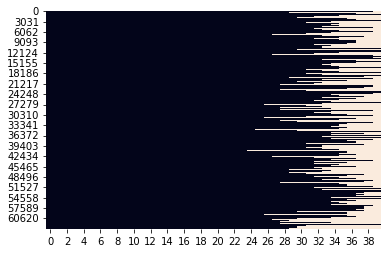

In [32]:
import seaborn as sns
#The feature matrix X_train has a shape of N documents x Sequences max length.
sns.heatmap(x_tr==0, vmin=0, vmax=1, cbar=False)
plt.show()

In [33]:
## TO DO EMBEDDING
#https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/


# load the whole embedding into memory
embeddings_index = dict()
f = open(r'/kaggle/input/glove100/glove.6B.100d.txt',encoding="utf8" )
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((x_voc_size, 100))
for word, i in x_tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Loaded 400000 word vectors.


In [45]:
#https://github.com/thushv89/attention_keras/blob/master/src/examples/nmt/model.py | FOR ATTENTION

### MODEL 1


Every LSTM layer should be accompanied by a Dropout layer. This layer will help to prevent overfitting by ignoring randomly selected neurons during training, and hence reduces the sensitivity to the specific weights of individual neurons. 20% is often used as a good compromise between retaining model accuracy and preventing overfitting.

In [34]:
#latent_dim = no. of layers, depth = 1, layers = 50
latent_dim = 64

embedding_dim = 100

# Encoder

#For this, we first must add an Input Layer, the only parameter to consider here is ‘shape’,
#which is the maximum length of the article, in our case max_len_text
encoder_inputs = Input(shape=(max_len_text, )) 

# Embedding layer
#input_dim = length of article(X) vocabulary
#output_dim = shape of embedding vector (100)
#This layer will convert input article to vactor shape of output vector(100)

enc_emb = Embedding(x_voc_size, 100, weights=[embedding_matrix], trainable=False)(encoder_inputs)

# Encoder LSTM 1
# right now the size is of latent dim, can be 64
encoder_lstm1 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.2,
                     recurrent_dropout=0.2)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb) # gives output, hiddent_state and context vector

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.2,
                     recurrent_dropout=0.2)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True,
                     return_sequences=True, dropout=0.2,
                     recurrent_dropout=0.2)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)

# Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(None, ))
###########################
# Embedding layer
dec_emb_layer = Embedding(y_voc_size, 100, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True, dropout=0.2,
                    recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = \
    decoder_lstm(dec_emb, initial_state=[state_h, state_c]) # takes encoder hiddent state

# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

 # Concat attention input and decoder LSTM output
decoder_concat_input = tf.keras.layers.Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input) #replace by decoder_concat_input for attention layer output

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

2022-12-17 04:45:42.843665: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-17 04:45:43.094601: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 04:45:43.095420: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-17 04:45:43.096131: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 100)      6548200     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 64), (No 42240       embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [35]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)



model.compile(optimizer=opt , loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

#model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
##Please note that I used the EarlyStopping tool in the callbacks that should stop training when a monitored metric (i.e. the validation loss) has stopped improving.
#This is particularly useful to save yourself some hours, especially for long and painful training like this one. I’d like to add that running Seq2Seq algorithms without leveraging GPUs is very hard because you are training 2 models at the same time (Encoder-Decoder).

In [36]:
history = model.fit(
    [x_tr, y_tr[:, :-1]],
    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
    epochs=10,
    callbacks=[es],
    batch_size=128,
    validation_data=([x_val, y_val[:, :-1]],
                     y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:
                     , 1:]),
    )

2022-12-17 04:48:56.300901: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
498/498 [==============================] - 356s 692ms/step - loss: 5.8484 - accuracy: 0.2861 - val_loss: 5.1364 - val_accuracy: 0.3663
Epoch 2/10
498/498 [==============================] - 342s 686ms/step - loss: 5.1268 - accuracy: 0.3610 - val_loss: 4.8791 - val_accuracy: 0.3732
Epoch 3/10
498/498 [==============================] - 343s 688ms/step - loss: 4.7831 - accuracy: 0.3722 - val_loss: 4.5526 - val_accuracy: 0.3848
Epoch 4/10
498/498 [==============================] - 341s 686ms/step - loss: 4.4875 - accuracy: 0.3839 - val_loss: 4.3498 - val_accuracy: 0.3948
Epoch 5/10
498/498 [==============================] - 343s 688ms/step - loss: 4.2611 - accuracy: 0.3944 - val_loss: 4.2015 - val_accuracy: 0.4021
Epoch 6/10
498/498 [==============================] - 340s 684ms/step - loss: 4.0727 - accuracy: 0.4049 - val_loss: 4.0897 - val_accuracy: 0.4098
Epoch 7/10
498/498 [==============================] - 338s 679ms/step - loss: 3.9104 - accuracy: 0.4143 - val_loss: 3.9940 -

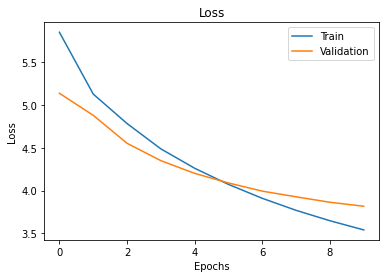

In [37]:
#validation Loss

from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='Train')
pyplot.plot(history.history['val_loss'], label='Validation')
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
pyplot.legend()
pyplot.show()

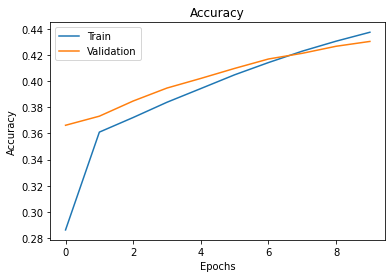

In [38]:
#accuracy

plt.figure()
plt.plot(history.history["accuracy"],label="Train");
plt.plot(history.history["val_accuracy"],label="Validation");
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show();

In [39]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [40]:
# #https://github.com/thushv89/attention_keras/blob/master/src/examples/nmt/model.py
# #https://github.com/thushv89/attention_keras/blob/master/src/examples/nmt/model.py

#https://github.com/MR-TLL/NLP-Project/blob/main/Group_22_final.ipynb
    
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [41]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_len_summary-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence


In [42]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString


 

In [43]:

for i in range(10,15):
    print("Review:",seq2text(x_test[i]))
    print("Original summary:",seq2summary(y_test[i]))
    print("Predicted summary:",decode_sequence(x_test[i].reshape(1,max_len_text)))
    print("\n")



Review: mohammad shami become third quickest indian fast bowler reach wickets test cricket playing test year old achieved feat taking wicket south africa keshav maharaj sunday kapil dev irfan pathan achieved landmark fewer test matches among indian pacers 
Original summary: start shami third fastest indian pacer to take test wickets end 
Predicted summary:  start rohit sharma becomes st odi to win in odis in odis end


Review: four people including one woman arrested allegedly manufacturing drug mephedrone worth crore factory palghar near mumbai intelligence agency raided factory seized litres drug liquid form friday agency also recovered handwritten notes manufacture mephedrone notably drug banned india 
Original summary: start banned drug worth crore seized near mumbai arrested end 
Predicted summary:  start mumbai police arrested for stealing seized in mumbai end


Review: denying reports dilip kumar deteriorating health wife saira banu said alright come back hospital recuperating h

In [45]:

pip install rouge

Note: you may need to restart the kernel to use updated packages.


In [46]:
from rouge import Rouge
ROUGE = Rouge()


In [47]:

summary_sentence = 'banned drug worth crore seized near mumbai arrested'
reference_sentence = 'mumbai police arrested for stealing seized in mumbai'


In [48]:
ROUGE.get_scores(summary_sentence, reference_sentence)

[{'rouge-1': {'r': 0.42857142857142855, 'p': 0.375, 'f': 0.3999999950222222},
  'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0},
  'rouge-l': {'r': 0.2857142857142857, 'p': 0.25, 'f': 0.266666661688889}}]

In [49]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [50]:
reference = [['banned', 'drug', 'worth', 'crore', 'seized', 'near', 'mumbai', 'arrested']]
            
candidate = ['mumbai', 'police', 'arrested',  'for', 'stealing', 'seized' ,'in', 'mumbai']

In [51]:
print (nltk.translate.meteor_score.meteor_score(
    reference, candidate))

0.1875
